# Analyse exploratoire


**1 - Importation des modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd

from utils.data import get_gender, get_states, get_postcode
from utils.coherence import correct_typo, find_best_similar, gestalt_pattern_matching
from utils.coherence import calculate_age, convert_to_date, postcode_coherence
from utils.eda import apply_gender, find_truth_age

**2 - Lecture des données**

In [2]:
df = pd.read_csv('df_patient_pcr.csv')
df = df.replace({np.nan: None})

In [3]:
df.head()

,patient_id,pcr,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,born_age,localisation,full_address,full_name
0,653091,N,daniel,campbell,58,sid barnes crescent,north ward,4514,nsw,1.97304e+07,None,08 38772117,None,19730426,4514 nsw north ward,58 sid barnes crescent,campbell daniel
1,347667,N,sebastian,mchenry,12,mundawari circuit,swan view,4551,wa,1.99003e+07,28,08 61083524,ocean star villas,19900316 28,4551 wa swan view,12 mundawari circuit,mchenry sebastian
2,708481,P,sarah,rellos,20,torres street,bribie island,3199,sa,1.94303e+07,None,02 73197286,None,19430317,3199 sa bribie island,20 torres street,rellos sarah
3,148825,N,chloe,brammy,238,fitchett street,carnegie,3280,qld,1.95405e+07,19,02 48826642,None,19540528 19,3280 qld carnegie,238 fitchett street,brammy chloe
4,150081,N,charlie,None,6,clark close,south melbourne,2602,qld,1.97503e+07,35,03 24096098,talawa,19750331 35,2602 qld south melbourne,6 clark close,charlie


## Pré-traitement des données

Avant de commencer l'analyse exploratoires, nous allons nettoyer la base de données et créer de nouvelles variables pouvant être pertinentes lors de l'analyse.  Enfin, nous sélectionnerons les variables utiles pour l'analyse pour créer notre jeu de données final.

### Création d'une variable `Gender`

On commence par corriger les prénoms mal orthographiés avec la fonction utilisée précédemment pour les adresses et la banlieue (`correct_typo`).

Après plusieurs itérations, une similtude à 85% entre deux chaînes de caractère semble convenir en prenant comme base de référence les prénoms apparaissant plus de 3 fois (pour ne pas corriger un prénom par un autre).

In [4]:
given_name_corrected = correct_typo(df.given_name, threshold=3,confidence=85)
df.given_name = df.given_name.replace(given_name_corrected)

On utilise ensuite une [API](https://genderize.io) qui fournit le sexe s'apparentant au mieux à un prénom, avec une probabilité indiquant la confiance de cette prédiction.

*NOTE : Toutefois, l'API limite ses requêtes et une exception est levée lors du seuil par jour atteind. Dans ce cas, la fonction renvoie donc la dernière données sauvegardée.*

In [5]:
unique_name = df.given_name.unique()
all_gender = get_gender(unique_name)

Request limit


On a donc notre nouvelle variable `gender`.

In [6]:
df["gender"] = apply_gender(all_gender, apply=df.given_name)
df[["gender","given_name"]].head()

,gender,given_name
0,male,daniel
1,male,sebastian
2,female,sarah
3,female,chloe
4,male,charlie


### Création de la variable `class_age`

Une seconde étape consiste à mettre en forme les données avant de créer une variable `class_age` calculée selon deux variable : `age` et `date_of_birth`.

In [4]:
df["age_estimated"] = calculate_age(df.date_of_birth, year=2020)
df["age"] = df.age.astype(float)

Pour appliquer la transformation en tranche d'âge (car il y a beaucoup d'erreurs de cohérence entre la date de naissances et l'age renseigné), on utilise le découpage effectué par les documents d'analyse de **Santé Publique France**.

- 0-14 ans
- 15-44 ans 
- 45-64 ans 
- 65-84 ans
- 85+

In [5]:
df["age_group"] = df.apply(
    lambda x : find_truth_age(x["age"], x["age_estimated"]), 
    axis=1)

df["age_group"] = df.age_group.replace({None: np.nan})

Pour chaque ligne, on compare simultanément **l'age estimé** et **l'age renseigné**.
- si les deux valeurs concordent (se trouvent dans la même classe d'âge) alors on applique la tranche d'age pour cette valeur.
- si une des deux valeurs est manquante, on impute la classe d'age à partir de l'autre valeur présente (en vérifiant la concordance).
- si les deux valeurs ne concordent pas (se trouve dans des classes d'âges différentes) alors on peut :

     - prendre la moyenne des valeurs et imputer pour cette nouvelles classe (mais cela peut fausser grandement les analyses).
     - vérifier la cohérence de chacune des valeurs et appliquer la plus probable (mais lorsque les deux valeurs sont probables, il est très difficile d'appliquer une règle).


In [6]:
round(df.age_group.isna().sum() / df.shape[0],3)

0.603

Seulement 40% (2886) des valeurs concordent lorsque nous découpons sous forme de classes entre la variable `age` et la variable `age_estimated` calculée à partir de la variable `date_of_birth`.

In [7]:
df[['age','age_estimated','date_of_birth','age_group']][
    df.age_group.isna()].sample(10)

,age,age_estimated,date_of_birth,age_group
42,34.0,79,19410812.0,NaN
5852,30.0,108,19120228.0,NaN
297,32.0,116,19040504.0,NaN
3365,30.0,118,19021030.0,NaN
3394,28.0,83,19370610.0,NaN
1360,43.0,61,19590907.0,NaN
4706,23.0,74,19460102.0,NaN
4537,30.0,120,19000710.0,NaN
6296,33.0,73,19470630.0,NaN
6593,7.0,103,19170520.0,NaN


On peut voir que sur un échantillon, les différences entre `age` et `age_estimated` ne font ressortir aucun *pattern*. Il vaut donc mieux laisser ce champ inconnu.

*NB : petite idée, trouver une base comprennant la moyenne d'âge pour un prénom et de réperer quel est l'age le plus concordant avec cette moyenne et imputer selon cette valeur.*

*NB2 : Une seconde pourrait être d'aller vérifier dans la table patient contenant les doublons, pour voir si pour ces valeurs les deux âges concordent*

### Nettoyage des variables : `postcode` et `state`

Nous appliquons ici les étapes que nous avons repérées lors du dernier notebook (correction des erreurs de typographie pour l'état et la vérification des codes postaux).

Pour les **états** : 

In [8]:
dict_ref = get_states()
df["state"] = find_best_similar(df.state, dict_ref, gestalt_pattern_matching)

Pour les **codes postaux** :

In [9]:
df["postcode"] = df.postcode.fillna(0)
df["postcode"] = df.postcode.astype(int)

Comme précédemment, les états et les code postaux ne correspondent pas pour tous les patients. On applique donc la fonction que nous avons utilisé pour connaître la cohérence de chacune et appliquer une valeur `None` si les deux informations ne concordent pas.

In [10]:
ref_post = get_postcode()
df["state_by_pc"] = postcode_coherence(
    serie=df.postcode, ref_postcode=ref_post, convert=False)

On peut vérifier le nombre d'incohérence entre états et code postaux (5833) soit 80% du jeu de données

In [11]:
df.shape[0] - sum(df.state_by_pc == df.state) 

5833

## Visualisation des données

### Map : États d'Australie

In [24]:
fp = "map/Australia_Polygon.shp"
map_df = gpd.read_file(fp)
map_df["name"] = map_df.name.replace(dict_ref)

In [ ]:
test = np.random.randint(1,100, size=(1,16))

In [33]:
map_df["test"] = pd.Series(test[0])

TypeError: object of type 'float' has no len()

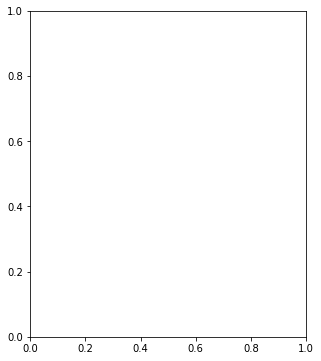

In [35]:
variable = 'test'
fig, ax = plt.subplots(1, figsize=(10, 6))
map_df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor=0.8)

In [16]:
map_df = map_df[["name","geometry"]]

In [18]:
data = pd.merge(df, map_df, left_on="state", right_on='name').drop(columns=["name"])